# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Надо что-то делать с пропусками

Думаем за фичи:
* PassengerId - удаляем
* Pclass - оставим как есть
* Name - вытащим обращение, перекодируем в циферки
* Sex - перекодируем в циферки
* Age - пропуски заменим медианой
* SibSp - оставляем как есть
* Parch - оставляем как есть
* Ticket - удаляем
* Fare - в тесте есть пустоты, заполняем медианой
* Cabin - возьмем первую букву, пустые значения заменим на 'n', перекодируем в циферки
* Embarked - пустые значения заменим на 'U', перекодируем в циферки

Делим выборку на тренировочную и валидационную

In [5]:
X = df.loc[:, df.columns != 'Survived']
y = df[['Survived']]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

Извлечем из имени обращение

In [7]:
X['Name'].apply(lambda x: x.split(', ', 1)[1].split(' ', 1)[0]).value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Major.         2
Mlle.          2
Don.           1
Sir.           1
Ms.            1
Lady.          1
Capt.          1
Mme.           1
Jonkheer.      1
the            1
Name: Name, dtype: int64

Есть редкие значения - есть вероятность непопадания какого-нибудь из них в тренировочную выборку - надо сохранить. Будем выделять только те, которые встречаются более одного раза.

In [8]:
honor_cat = [list(X['Name'].apply(lambda x: x.split(', ', 1)[1].split(' ', 1)[0]).unique()) + ['Unk.']]

In [9]:
honor_cat[0]

['Mr.',
 'Mrs.',
 'Miss.',
 'Master.',
 'Don.',
 'Rev.',
 'Dr.',
 'Mme.',
 'Ms.',
 'Major.',
 'Lady.',
 'Sir.',
 'Mlle.',
 'Col.',
 'Capt.',
 'the',
 'Jonkheer.',
 'Unk.']

In [10]:
class HonorificExtractor(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self):
        self._honor_cat = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.', 'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'the', 'Jonkheer.'] # т.к. склерн - глючное говно (как и все, что пишут математики? а не программисты, хардкодим)
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        X['Honorific'] = X['Name'].apply(lambda x: x.split(', ', 1)[1].split(' ', 1)[0] if x.split(', ', 1)[1].split(' ', 1)[0] in self._honor_cat else 'Unk.')
        
        return X[['Honorific']]


In [11]:
h = HonorificExtractor()
h.transform(X)['Honorific'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Major.         2
Mlle.          2
Don.           1
Sir.           1
Ms.            1
Lady.          1
Capt.          1
Mme.           1
Jonkheer.      1
the            1
Name: Honorific, dtype: int64

Трансформер ColumnTransformer не может одновременно оставить часть фичей неизмененными, а часть удалить, поэтому создаим трансформер-пустышку

In [12]:
class Passthrough(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self):
        pass
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X

In [13]:
class CabinTransformer(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self):
        pass
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        X['Cabin'] = X['Cabin'].apply(lambda x: str(x)[0])
        return X[['Cabin']]

In [14]:
c = CabinTransformer()
c.transform(X)['Cabin'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

Тоже есть вероятность не получить в тренировочную выборку часть даных

In [15]:
cabin_cat = [list(c.transform(X)['Cabin'].unique())]

In [16]:
X['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

В процессинге мы NaN заменим на U, поэтому список кадеторий будет таким:

In [17]:
emb_cat = [['S', 'C', 'Q', 'U']]

Из всего этого собираем предпроцессор данных

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('passthrough', Passthrough(), ['Pclass', 'SibSp', 'Parch']),
        ('honorific', Pipeline(steps=[
            ('extractor', HonorificExtractor()),
            ('encoder', OrdinalEncoder(categories=honor_cat))
        ]), ['Name']),
        ('sex', OrdinalEncoder(), ['Sex']),
        ('age', SimpleImputer(missing_values=np.NaN, strategy="mean"), ['Age']),
        ('cabin', Pipeline(steps=[
            ('extractor', CabinTransformer()),
            ('encoder', OrdinalEncoder(categories=cabin_cat))
        ]), ['Cabin']),
        ('fare', SimpleImputer(missing_values=np.NaN, strategy="mean"), ['Fare']),
        ('embarked', Pipeline(steps=[
            ('missing', SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value='U')),
            ('encoder', OrdinalEncoder(categories=emb_cat))
        ]), ['Embarked'])
    ],
    sparse_threshold=0,
    remainder='drop'
)

Собираем классификатор

In [19]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

Определяем параметры, которые будем перебирать

In [20]:
grid_params = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': range(3, 11),
    'classifier__min_samples_leaf': range(1, 8),
    'classifier__min_samples_split': range(2, 5)
}

In [21]:
grid = GridSearchCV(clf, param_grid=grid_params, n_jobs=-1, cv=10, scoring='accuracy')

In [22]:
grid.fit(X_train, y_train)

/home/vvodan/.pyenv/versions/titanic/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0,
                                                          transformer_weights=None,
                                                          transformers=[('passthrough',
                                                                         Passthrough(),
                                                                         ['Pclass',
                                                                          'SibSp',
                                                                          'Parch']),
                                                                        ('honorific',
                       

Смотрим, что получилось

In [23]:
grid.best_score_

0.824438202247191

In [24]:
grid.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2}

Дерево получилось совсем не глубоким

In [38]:
estimator = grid.best_estimator_

In [39]:
estimator.named_steps['classifier'].feature_importances_

array([0.1312502 , 0.        , 0.        , 0.63259746, 0.02673417,
       0.04481854, 0.01423626, 0.15036337, 0.        ])

Надо собрать название фич из препроцессинга

In [40]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [41]:
df_features = pd.DataFrame()
df_features['Features'] = pd.Series(get_column_names_from_ColumnTransformer(estimator.named_steps['preprocessor']))
df_features['Feature importances'] = estimator.named_steps['classifier'].feature_importances_
df_features

,Features,Feature importances
0,Pclass,0.131250
1,SibSp,0.000000
2,Parch,0.000000
3,Name,0.632597
4,Sex,0.026734
5,Age,0.044819
6,Cabin,0.014236
7,Fare,0.150363
8,Embarked,0.000000


Под полем Name у нас кроется вежливое обращение - больше всего влияет на шансы выжить. Любопытно, но важная фича Sex показывает низкую значимость - это связано с тем, что фича Name включает в себя эту фичу.

In [54]:
gr = export_graphviz(estimator.named_steps['classifier'], out_file=None, filled=True, feature_names=list(df_features['Features']), class_names=['dead', 'alive'])

In [64]:
(img,) = pydot.graph_from_dot_data(gr)

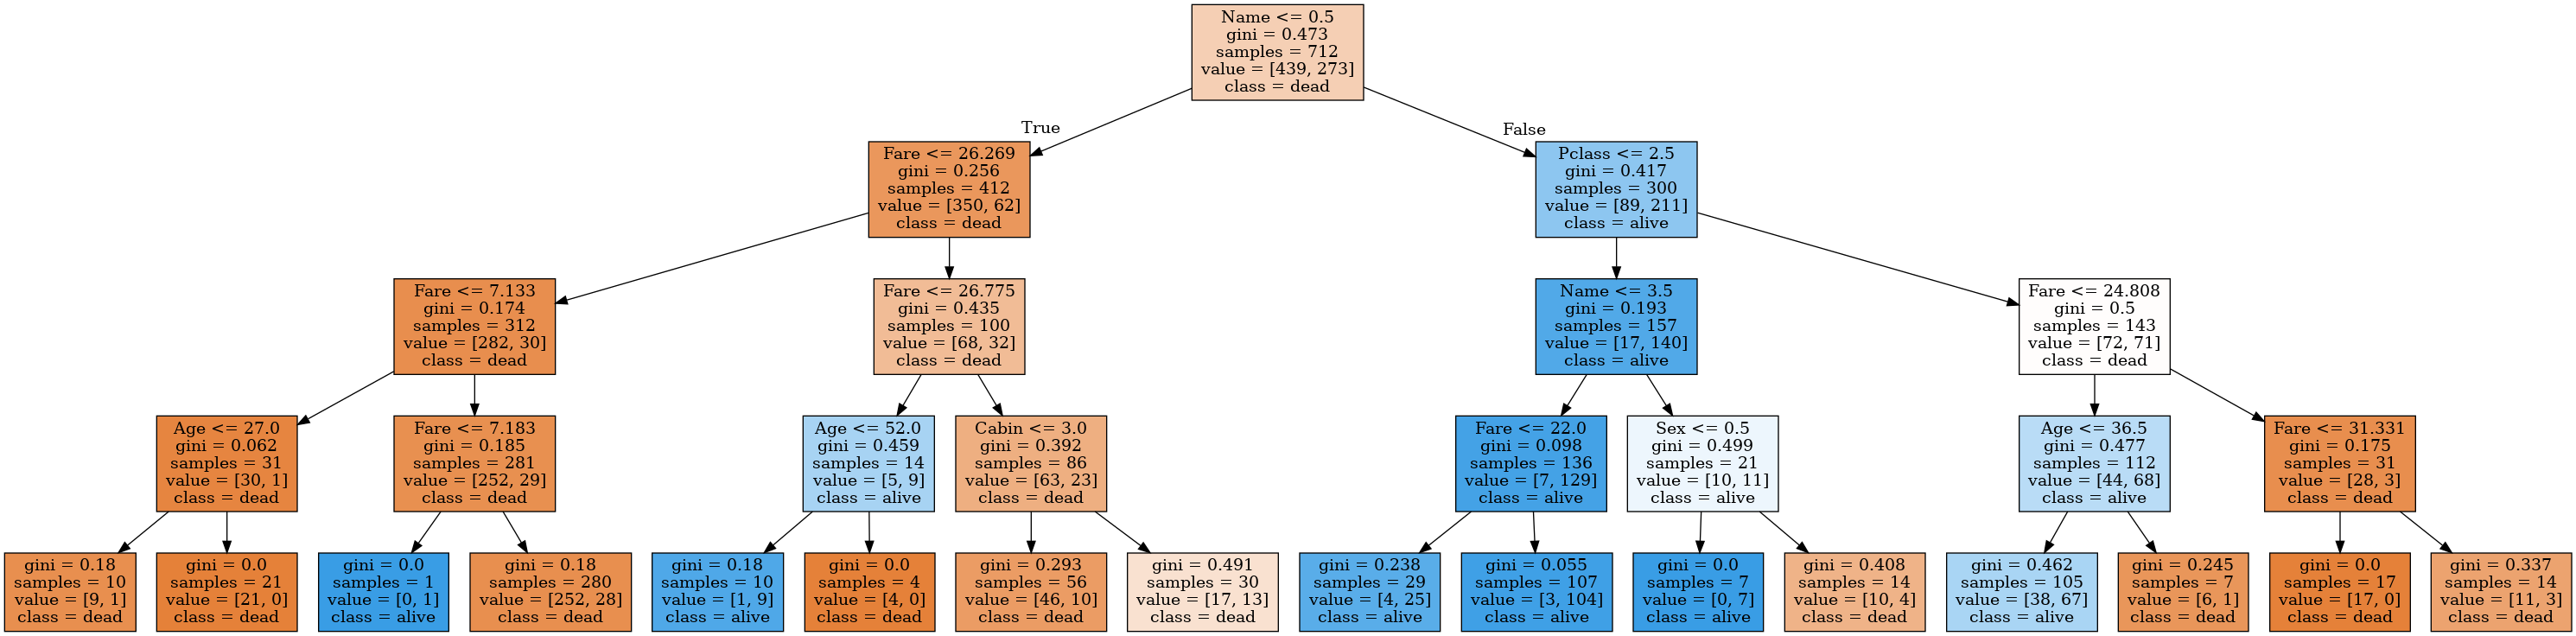

In [65]:
Image(img.create_png())

Построим ROC-AUC

In [29]:
def plt_roc_auc(title, fpr_train, tpr_train, roc_auc_train, fpr_test, tpr_test, roc_auc_test):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC {roc_auc_train}')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC {roc_auc_test}')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()    

In [30]:
y_train_pred = estimator.predict(X_train)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)

In [31]:
y_val_pred = estimator.predict(X_val)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_pred)

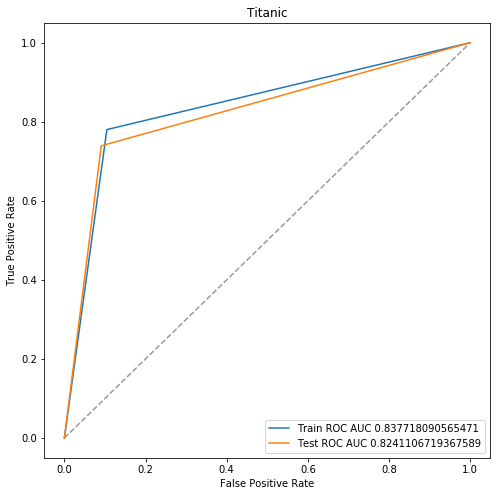

In [32]:
plt_roc_auc('Titanic', fpr_train, tpr_train, roc_auc_train, fpr_val, tpr_val, roc_auc_val)

Построим PRC-AUC

In [33]:
def plt_prc_auc(title, precision_train, recall_train, average_precision_train, precision_test, recall_test, average_precision_test):
    plt.figure(figsize=(8, 8))
    plt.plot(recall_train, precision_train, label=f'Train PRC AUC, AP={average_precision_train}')
    plt.plot(recall_test, precision_test, label=f'Test PRC AUC, AP={average_precision_test}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.show()    

In [34]:
y_score_train = estimator.predict_proba(X_train)[:, 1]
precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
ap_train = average_precision_score(y_train, y_score_train)

In [35]:
y_score_val = estimator.predict_proba(X_val)[:, 1]
precision_val, recall_val, _ = precision_recall_curve(y_val, y_score_val)
ap_val = average_precision_score(y_val, y_score_val)

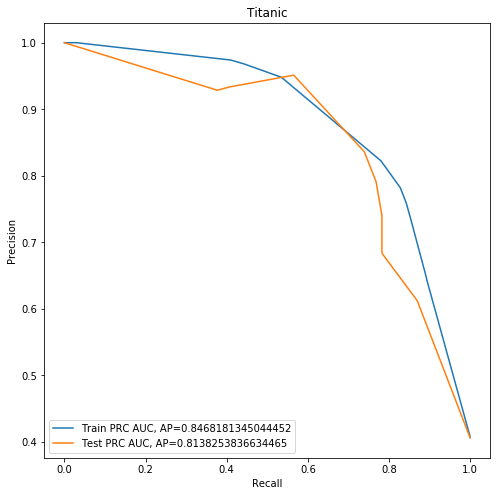

In [36]:
plt_prc_auc('Titanic', precision_train, recall_train, ap_train, precision_val, recall_val, ap_val)

Теперь просчитаем тест для кегли

In [37]:
df_test = pd.read_csv('test.csv')

In [42]:
test_predict = estimator.predict(df_test)

In [45]:
submission = pd.DataFrame()
submission['PassengerId'] = df_test['PassengerId']
submission['Survived'] = pd.Series(test_predict)
submission.to_csv("submission.csv", index=False)